In [1]:
print("final gen_TR1 Version4")

final gen_TR1 Version4


tairens latest code taken from tryin3_TR

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import pandas as pd
import sys
import PIL
import os
from io import BytesIO
# from generated_color_by_contrast import ensure_readable_colors, contrast_ratio

def crop_extra_boundary(image:PIL.Image) -> PIL.Image:
    img_array = np.array(image)
    
    # For transparent PNG, find the alpha channel (if it exists)
    if img_array.shape[2] == 4:  # RGBA
        # Find non-transparent pixels
        non_empty_columns = np.where(img_array[:, :, 3].max(axis=0) > 0)[0]
        non_empty_rows = np.where(img_array[:, :, 3].max(axis=1) > 0)[0]
    else:  # RGB
        # Use inverted approach - find non-white pixels (assuming white background)
        is_not_white = (img_array[:, :, 0] < 255) | (img_array[:, :, 1] < 255) | (img_array[:, :, 2] < 255)
        non_empty_columns = np.where(is_not_white.any(axis=0))[0]
        non_empty_rows = np.where(is_not_white.any(axis=1))[0]
    
    # Crop the image to content only if there are non-empty pixels
    if len(non_empty_rows) > 0 and len(non_empty_columns) > 0:
        cropped_img = img_array[
            min(non_empty_rows):max(non_empty_rows) + 1,
            min(non_empty_columns):max(non_empty_columns) + 1
        ]
        # Convert back to PIL
        final_img = Image.fromarray(cropped_img)
    else:
        final_img = image
    
    return final_img


def generate_text_image(
    main_text="Text",
    super_text=None,
    sub_text=None,
    text_color=(0.0, 0.0, 0.0, 1.0),
    font_size=22,
    left_adjustment=0.02,
    super_sub_position=0.5, # For the superscript, it moves higher; for subscript, it moves lower
    super_sub_size=5, # define the superscript or subscript font size
    dpi=300,
    font_type = 'serif',
    text_bold = "False",
    transparent=True
):
    """
    Generate an image with just text (superscript/subscript)
    """
    # Create combined text
    combined_text = main_text
    
    super_sub_position = str(super_sub_position) + "ex"
    # super_sub_size = super_sub_size_map[super_sub_size]
    
    buf = BytesIO()
    #special case for $ adn percent ##################
    # if "$" in main_text or "%" in main_text or "#" in main_text or "&" in main_text or "\\" in main_text:
    #     main_text = main_text.replace("\\", "").replace("$", "\$").replace("%", "\%").replace("#", "\#").replace("&", "\&")

    if "$" in main_text or "%" in main_text or "#" in main_text or "&" in main_text:
        main_text = main_text.replace("$", "\$").replace("%", "\%").replace("#", "\#").replace("&", "\&")
    #############################################################
    if super_text and not sub_text:
        super_or_sub = 0
            
        if text_bold:
            combined_text = f"\\textbf{{{main_text}}}$^{{\\raisebox{{{super_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont {super_text}}}}}$"
        else:
            combined_text = f"{main_text}$^{{\\raisebox{{{super_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont {super_text}}}}}$"
        
        # Add space between the main text and superscript
        # combined_text = f"{main_text}\\hspace{{0.2em}}$^{{\\raisebox{{{super_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont {super_text}}}}}$"
    
    elif sub_text and not super_text:
        super_or_sub = 1
        super_sub_position = "-" + super_sub_position        
        if text_bold:
            combined_text = f"\\textbf{{{main_text}}}$_{{\\raisebox{{{super_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont  {sub_text}}}}}$"
        else:
            combined_text = f"{main_text}$_{{\\raisebox{{{super_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont  {sub_text}}}}}$"
    
    elif super_text and sub_text:
        super_or_sub = 2
        adjusted_sub_position = "-" + super_sub_position  # for subscript (negative lift)
        if text_bold:
            combined_text = (
                f"\\textbf{{{main_text}}}"
                f"$^{{\\raisebox{{{super_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont {super_text}}}}}"
                f"_{{\\raisebox{{{adjusted_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont {sub_text}}}}}$"
            )
        else:
            combined_text = (
                f"{main_text}"
                f"$^{{\\raisebox{{{super_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont {super_text}}}}}"
                f"_{{\\raisebox{{{adjusted_sub_position}}}{{\\fontsize{{{super_sub_size}}}{{0}}\\selectfont {sub_text}}}}}$"
            )

    else:
        # If neither super_text nor sub_text
        super_or_sub = -1
        combined_text = main_text
    
    
    # Set font
    font_prop = None
    rcParams['text.usetex'] = True
    rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
    if font_type.lower() in ['serif', 'sans-serif', 'monospace']:
        rcParams['mathtext.fontset'] = 'custom'
        rcParams['mathtext.rm'] = font_type.lower()
    elif os.path.isfile(font_type):
        # Load TTF font
        font_prop = FontProperties(fname=font_type)
    else:
        raise ValueError("font_type must be 'serif', 'sans-serif', 'monospace', or a valid .ttf path")


    # Create figure
    fig_width = len(combined_text) * font_size / 50
    fig_height = font_size / 50 * 1.5
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
        
    # Add text with slight position adjustment
    text = ax.text(
        0.5 - left_adjustment, 0.5, combined_text,
        ha='center', va='center',
        fontsize=font_size,
        color=text_color,
        fontproperties=font_prop,
        transform=ax.transAxes
    )
    
    # First draw to get the bbox
    fig.canvas.draw()
    bbox = text.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        
    # Update figure size
    # to avoid cutting the top of superscirpt, increase the bbox.height by 50%
    # then crop it late
    fig.set_size_inches(bbox.width, bbox.height * 1.5 )
    
    # Create a tight layout, which is sensitive to padding
    plt.tight_layout(pad=0)
    
    # Save the image
    plt.savefig(
        buf,
        bbox_inches='tight',
        pad_inches=0,
        transparent=transparent,
        dpi=dpi
    )
    
    # save it for testing
    plt.savefig(
        "./current_test.png",
        bbox_inches='tight',
        pad_inches=0,
        transparent=transparent,
        dpi=dpi
    )
    buf.seek(0)
    gen_image = Image.open(buf)
    
    # crop the white space previously added by increasing the bbox.height
    gen_image = crop_extra_boundary(gen_image)
    
    plt.close()
    
    # Return the dimensions of the generated image
    # img = Image.open(output_path)
    return gen_image.size, gen_image, super_or_sub


def gen_image_random_sample_(wdith_range_bd, height_range_bd, text_size, background_img, pad_all):
    pad_left, pad_top, pad_right, pad_bottom = pad_all
    text_w, text_h = text_size
    sample_width_left = np.random.randint(pad_left, wdith_range_bd + 1)
    sample_height_top = np.random.randint(pad_top, height_range_bd + 1)
    sample_width_right = sample_width_left + text_w
    sample_height_bottom = sample_height_top + text_h
    
    cropped_image = background_img.crop((sample_width_left, sample_height_top, sample_width_right, sample_height_bottom))
    cropped_img_rgb = np.array(cropped_image).mean(axis=(0,1))   
    return cropped_img_rgb, cropped_image, [sample_width_left, sample_height_top, sample_width_right, sample_height_bottom]


def sample_from_bgImage(background_img:Image, text_img_size:list, pad_all:list, generated_text_color:tuple, min_contrast:float =4.5):
    img_w, img_h = background_img.size
    text_w, text_h = text_img_size
    pad_left, pad_top, pad_right, pad_bottom = pad_all

    wdith_range_bd = img_w - text_w - pad_left - pad_right
    height_range_bd = img_h - text_h - pad_top - pad_bottom

    if wdith_range_bd > 0 and height_range_bd > 0:
                
        cropped_img_rgb, cropped_image, sample_indices = gen_image_random_sample_(wdith_range_bd, height_range_bd, [text_w, text_h], background_img, pad_all)
        
        count_contrast = 0
        use_bg = True
        
        while contrast_ratio(generated_text_color, cropped_img_rgb) < min_contrast:
            cropped_img_rgb, cropped_image, sample_indices = gen_image_random_sample_(wdith_range_bd, height_range_bd, [text_w, text_h], background_img, pad_all)
            if count_contrast > 20:
                print("background does not have enough contrast with text")
                print("Generate the background instead")
                use_bg = False
                break
            count_contrast += 1
        
        [sample_width_left, sample_height_top, sample_width_right, sample_height_bottom] = sample_indices
        extend_left = sample_width_left - pad_left
        extend_right = sample_width_right + pad_right
        extend_top = sample_height_top - pad_top
        extend_bottom = sample_height_bottom + pad_bottom
        
        if not use_bg:
            text_width = sample_width_right - sample_width_left
            text_height = sample_height_bottom - sample_height_top
            upd_text_width = text_width + pad_left + pad_right
            upd_text_height = text_height + pad_top + pad_bottom
            generated_text_color, generated_bkground_color, new_ctr = ensure_readable_colors(generated_text_color, cropped_img_rgb, fix_color=1)
            cropped_image = Image.new('RGBA', (text_width, text_height), generated_bkground_color)
            background_img_ext = Image.new('RGBA', (upd_text_width, upd_text_height), generated_bkground_color)
            
        else:    
            background_img_ext = background_img.crop((extend_left, extend_top, extend_right, extend_bottom))
            
        return cropped_image, background_img_ext
                
    else:
        return None, None


def overlay_on_background(
    gen_text_image,
    output_path,
    generated_text_color,
    background_image_path=None,
    gen_bg_color='white',
    pad_all = [0, 0, 0, 0],
):
    """
    Overlay the text image on a background image
    
    Parameters:
    -----------
    text_image_path : str
        Path to the text image
    background_image_path : str
        Path to the background image
    output_path : str
        Path to save the combined image
    position : str or tuple
        'center' or (x, y) coordinates for positioning
    scale_background : bool
        If True, scales the background to match text size
        If False, crops the background to match text size
    """
    try:
        # Open the images
        text_img = gen_text_image #Image.open(text_image_path)        
        # Get dimensions
        text_width, text_height = text_img.size
        
        # Crop background to match text dimensions
        # If background is smaller than text, it will be centered
        pad_left, pad_top, pad_right, pad_bottom = pad_all
        if background_image_path is None:
            # Create a new blank image with text dimensions
            upd_text_width = text_width + pad_left + pad_right
            upd_text_height = text_height + pad_top + pad_bottom
            
            background_img = Image.new('RGBA', (text_width, text_height), gen_bg_color)
            background_img_ext = Image.new('RGBA', (upd_text_width, upd_text_height), gen_bg_color)
            
        else:
            background_img = Image.open(background_image_path)
            background_img, background_img_ext = sample_from_bgImage(background_img, [text_width, text_height], pad_all, generated_text_color)
        
        # Create a new image with RGBA mode to handle transparency
        combined_img = Image.new('RGBA', text_img.size, (0, 0, 0, 0))
        
        # Paste the background first
        combined_img.paste(background_img, (0, 0))
    
        # Overlay the text (with transparency)
        if text_img.mode == 'RGBA':
            combined_img = Image.alpha_composite(combined_img, text_img)
        else:
            # Convert to RGBA if needed
            text_img_rgba = text_img.convert('RGBA')
            combined_img = Image.alpha_composite(combined_img, text_img_rgba)
    
        # Save the combined image
        # combined_img.save(output_path)
        print(f"Combined image saved to {output_path}")
        background_img_ext.paste(combined_img, (pad_left, pad_top))
        background_img_ext.save(output_path)
    
    
    except Exception as e:
        print(f"Error overlaying images: {e}")


def normalize_rgba(rgba):
    return tuple(c / 255 for c in rgba)


def denormalize_rgba(rgba):
    return tuple(255 * c for c in rgba)





##############################################################################
# using The Web Content Accessibility Guidelines (WCAG) define specific contrast requirements:
#
#
#

import random
import numpy as np

def get_luminance(color):
    """Calculate relative luminance of an RGB color"""
    if len(color) > 3:
        color = color[:3]
    r, g, b = [c/255 for c in color]
    
    # Convert to sRGB
    r = r/12.92 if r <= 0.03928 else ((r+0.055)/1.055)**2.4
    g = g/12.92 if g <= 0.03928 else ((g+0.055)/1.055)**2.4
    b = b/12.92 if b <= 0.03928 else ((b+0.055)/1.055)**2.4
    
    return 0.2126 * r + 0.7152 * g + 0.0722 * b


def contrast_ratio(color1, color2):
    """Calculate contrast ratio between two colors"""
    lum1 = get_luminance(color1)
    lum2 = get_luminance(color2)
    
    # Ensure lighter color is first
    if lum1 < lum2:
        lum1, lum2 = lum2, lum1
        
    return (lum1 + 0.05) / (lum2 + 0.05)


def generate_contrasting_colors(fixed_color, min_contrast=4.5):
    """Generate text and background colors with minimum contrast ratio"""
    while True:
        # Generate random background color
        gen_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            
        # Check if contrast is sufficient
        new_ctr = contrast_ratio(fixed_color, gen_color)
        if new_ctr >= min_contrast:
            return fixed_color, gen_color, new_ctr


def ensure_readable_colors(text_color_in, bg_color_in, min_contrast=4.5, fix_color=1):
    """
    fix_color: whether to fix color or not
             1: fix the text color 
             2: fix the background color
    Check if text and background colors have enough contrast.
    If not, adjust the text color for better readability.
    """
    if len(text_color_in) > 3:
        text_color = text_color_in[:3]
    else:
        text_color = text_color_in
    
    if len(bg_color_in) > 3:
        bg_color = bg_color_in[:3]
    else:
        bg_color = bg_color_in
    
    cr = contrast_ratio(text_color, bg_color)
    
    if cr >= min_contrast:
        return text_color, bg_color, cr
    
    if fix_color == 1:
        text_color, bg_color, new_ctr = generate_contrasting_colors(text_color)
    else:
        text_color, bg_color, new_ctr = generate_contrasting_colors(bg_color)
        
    if len(text_color) == 3 and len(text_color_in) == 4:
        text_color_list = list(text_color)
        text_color_list.append(text_color_in[-1])
        text_color = tuple(text_color_list)
        
    if len(bg_color) == 3 and len(bg_color_in) == 4:
        bg_color_list = list(bg_color)
        bg_color_list.append(bg_color_in[-1])
        bg_color = tuple(bg_color_list)

    return text_color, bg_color, new_ctr

##############################################################################



generation function

create function to create train and test set

In [3]:
import os 
import random
def create_main_text_files(file_path1 = None, 
                           file_path2 = None , 
                           file_path3=None,
                           percent1=0.5,
                           percent2=0.5,
                           percent3=0.5,
                           num_samples=1000,
                           output_path = None,
                           test = False):
    #take percent1 words from file_path1
    total_percent = percent1 + percent2 + percent3
    if total_percent != 1:
        raise ValueError("Sum of percentages must be equal to 1")
    os.makedirs(output_path, exist_ok=True)
    words1 = []
    words2 = []
    words3 = []
    
    
    #store words
    if file_path1:
        with open(file_path1, 'r', encoding='utf-8') as f:
            words1 = [line.strip() for line in f if line.strip()]
    if file_path2:
        with open(file_path2, 'r', encoding='utf-8') as f:
            words2 = [line.strip() for line in f if line.strip()]
    if file_path3:
        with open(file_path3, 'r', encoding='utf-8') as f:
            words3 = [line.strip() for line in f if line.strip()]
    # Calculate number of samples per file
    num_words1 = int(num_samples * percent1)
    num_words2 = int(num_samples * percent2)
    num_words3 = int(num_samples * percent3)
    # Make sure we don't sample more than available
    num_words1 = min(num_words1, len(words1))
    num_words2 = min(num_words2, len(words2))
    num_words3 = min(num_words3, len(words3))
    
    # Sample words from each list
    if words1 and  num_words1 > 0:
        sampled_words1 = random.sample(words1, num_words1)
    if words2 and num_words2 > 0:
        sampled_words2 = random.sample(words2, num_words2)
    if words3 and num_words3 > 0:
        sampled_words3 = random.sample(words3, num_words3)
    #write to output file
    num_sample_1 = len(sampled_words1) if num_words1 > 0 else 0
    num_sample_2 = len(sampled_words2) if num_words2 > 0 else 0
    num_sample_3 = len(sampled_words3) if num_words3 > 0 else 0
    
    if num_sample_1 + num_sample_2 + num_sample_3 < num_samples:
        #choose the remaining words from the first two files chosen randomly
        remaining_words = num_samples - (num_sample_1 + num_sample_2 + num_sample_3)
        words_to_choose_from =  words1 + words2
        words_already_chosen = sampled_words1 + sampled_words2
        words_to_choose_from = [word for word in words_to_choose_from if word not in words_already_chosen]
        if len(words_to_choose_from) < remaining_words:
            raise ValueError("Not enough words to sample from the first two files")
        sampled_remaining_words = random.sample(words_to_choose_from, remaining_words)
        sampled_words1 += sampled_remaining_words
        num_sample_1 = len(sampled_words1)
        num_sample_2 = len(sampled_words2)
         
            
    
    output_file = 'test_main_text.txt' if test else 'train_main_text.txt'
    with open(os.path.join(output_path, output_file), 'w', encoding='utf-8') as f:
        if num_words1 > 0:
            for word in sampled_words1:
                f.write(word + '\n')
        if num_words2 > 0:
            for word in sampled_words2:
                f.write(word + '\n')
        if num_words3 > 0 and test == False:
            for word in sampled_words3:
                f.write(word + '\n')
    
    if test == False:
        print(f"train_main_text.txt created with {num_sample_1 + num_sample_2 + num_sample_3} words saved to {output_path}")
        print(f"{num_sample_1} words from {file_path1}")
        print(f"{num_sample_2} words from {file_path2}")
        print(f"{num_sample_3} words from {file_path3}")
    
    else:
        print(f"test_main_text.txt created with {num_words1 + num_words2} words saved to {output_path}")
        print(f"{num_sample_1} words from {file_path1}")
        print(f"{num_sample_2} words from {file_path2}")  
    
        
    

create train dataset

In [27]:
create_main_text_files(file_path1 = "../words1/output2/train_data_words_TR/unique_texts.txt", 
                           file_path2 = "../words1/output2/train_data_words_TR/unique_nums.txt", 
                           file_path3="../words1/output_json_1_TR/output_unique_individual_words.txt",
                           percent1=0.46,
                           percent2=0.27,
                           percent3=0.27,
                           num_samples=10000,
                           output_path = "./data_1/train_1_TR",
                           test = False)

train_main_text.txt created with 10000 words saved to ./data_1/train_1_TR
6945 words from ../words1/output2/train_data_words_TR/unique_texts.txt
2700 words from ../words1/output2/train_data_words_TR/unique_nums.txt
355 words from ../words1/output_json_1_TR/output_unique_individual_words.txt


For fine-tune purpose

In [24]:
create_main_text_files(file_path1 = "/app/super_sub_script_1/words1/gt_unique_words.txt", 
                           file_path2 = "../words1/output2/train_data_words_TR/unique_nums.txt", 
                           file_path3="../words1/output_json_1_TR/output_unique_individual_words.txt",
                           percent1=0.9,
                           percent2=0.05,
                           percent3=0.05,
                           num_samples=6000,
                           output_path = "./data_1/train_2_TR_ft",
                           test = False)

train_main_text.txt created with 6000 words saved to ./data_1/train_2_TR_ft
5400 words from /app/super_sub_script_1/words1/gt_unique_words.txt
300 words from ../words1/output2/train_data_words_TR/unique_nums.txt
300 words from ../words1/output_json_1_TR/output_unique_individual_words.txt


create test dataset

In [28]:
create_main_text_files(file_path1 = "../words1/output2/train_data_words_TR/unique_texts.txt", 
                           file_path2 = "../words1/output2/train_data_words_TR/unique_nums.txt", 
                           file_path3="../words1/output_json_1_TR/output_unique_individual_words.txt",
                           percent1=0.60,
                           percent2=0.40,
                           percent3=0.0,
                           num_samples=1200,
                           output_path = "./data_1/test_1_TR",
                           test = False)

train_main_text.txt created with 1200 words saved to ./data_1/test_1_TR
720 words from ../words1/output2/train_data_words_TR/unique_texts.txt
480 words from ../words1/output2/train_data_words_TR/unique_nums.txt
0 words from ../words1/output_json_1_TR/output_unique_individual_words.txt


 For test dataset fine-tune purpose

In [25]:
create_main_text_files(file_path1 = "/app/super_sub_script_1/words1/gt_unique_words.txt", 
                           file_path2 = "../words1/output2/train_data_words_TR/unique_nums.txt", 
                           file_path3="../words1/output_json_1_TR/output_unique_individual_words.txt",
                           percent1=0.9,
                           percent2=0.05,
                           percent3=0.05,
                           num_samples=600,
                           output_path = "./data_1/test_2_TR_ft",
                           test = False)

train_main_text.txt created with 600 words saved to ./data_1/test_2_TR_ft
540 words from /app/super_sub_script_1/words1/gt_unique_words.txt
30 words from ../words1/output2/train_data_words_TR/unique_nums.txt
30 words from ../words1/output_json_1_TR/output_unique_individual_words.txt


guasain function

In [4]:
import numpy as np
from scipy.stats import truncnorm

def sample_truncnorm_with_tail_and_baseline(min_val, max_val, mean, std,
                                             tail_smooth='both',
                                             suppression_strength=3.0,
                                             baseline_weight=0.2,
                                             size=1000, grid_points=1000, seed=None,
                                             return_pdf=False):

    if seed is not None:
        np.random.seed(seed)

    if tail_smooth not in ['left', 'right', 'both', None]:
        raise ValueError("tail_smooth must be 'left', 'right', 'both', or None")

    # Step 1: Grid over support
    x = np.linspace(min_val, max_val, grid_points)

    # Step 2: Truncated normal PDF
    a = (min_val - mean) / std
    b = (max_val - mean) / std
    gauss_pdf = truncnorm.pdf(x, a=a, b=b, loc=mean, scale=std)

    # Step 3: Exponential tail suppression
    if tail_smooth in ['left', 'both']:
        mask_left = x < mean
        decay_left = np.exp(-suppression_strength * (mean - x[mask_left]))
        gauss_pdf[mask_left] *= decay_left

    if tail_smooth in ['right', 'both']:
        mask_right = x > mean
        decay_right = np.exp(-suppression_strength * (x[mask_right] - mean))
        gauss_pdf[mask_right] *= decay_right

    # Step 4: Uniform baseline PDF
    baseline_pdf = np.ones_like(x) / (max_val - min_val)

    # Step 5: Mix PDFs
    mixed_pdf = (1 - baseline_weight) * gauss_pdf + baseline_weight * baseline_pdf

    # Step 6: Normalize
    mixed_pdf /= mixed_pdf.sum()

    # Step 7: Sample
    samples = np.random.choice(x, size=size, p=mixed_pdf)

    if return_pdf:
        return samples, x, mixed_pdf
    return samples
###########################################################################
import matplotlib.pyplot as plt

def plot_sample_histogram(samples, x=None, pdf=None,
                          bins=50, title="Sampled Value Distribution"):
    plt.figure(figsize=(10, 6))

    # Plot histogram
    counts, bins, _ = plt.hist(samples, bins=bins, density=True,
                               alpha=0.7, color='#4a90e2',
                               edgecolor='white', linewidth=1.2,
                               label="Sample Histogram")

    # Overlay PDF if provided
    if x is not None and pdf is not None:
        plt.plot(x, pdf, color='crimson', lw=2, label='Theoretical PDF')

    # Titles and labels
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Grid and legend
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

sample digits

In [5]:
def plot_distribution(sampler_func, label, num_samples=10000):
    samples = [sampler_func() for _ in range(num_samples)]
    freq = {c: samples.count(c)/num_samples for c in set(samples)}
    
    sorted_freq = dict(sorted(freq.items()))
    
    plt.figure(figsize=(10, 4))
    bars = plt.bar(sorted_freq.keys(), sorted_freq.values())
    plt.title(f"{label} Frequency Distribution")
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', axis='y', alpha=0.5)

    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                 f'{height*100:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

In [6]:
def sample_digit():
    digits = list('123456789')
    n = len(digits)
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=0.0,  # peak at '1'
        std=3.0,
        tail_smooth='right',
        baseline_weight=0.1,
        suppression_strength=1.5,
        size=1,
        return_pdf = False
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    return digits[idx]

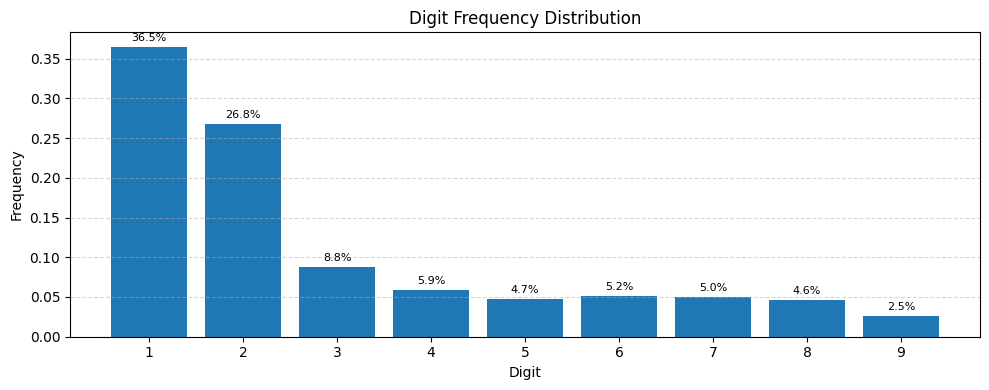

In [12]:
plot_distribution(sample_digit, "Digit", num_samples=10000)

In [7]:
def sample_lower():
    letters = list('abcdefghijklmnopqrstuvwxyz')
    n = len(letters)
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=0.0,  # peak at 'a'
        std=5,
        tail_smooth='right',
        baseline_weight=0.1,
        suppression_strength=1.5,
        size=1
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    return letters[idx]

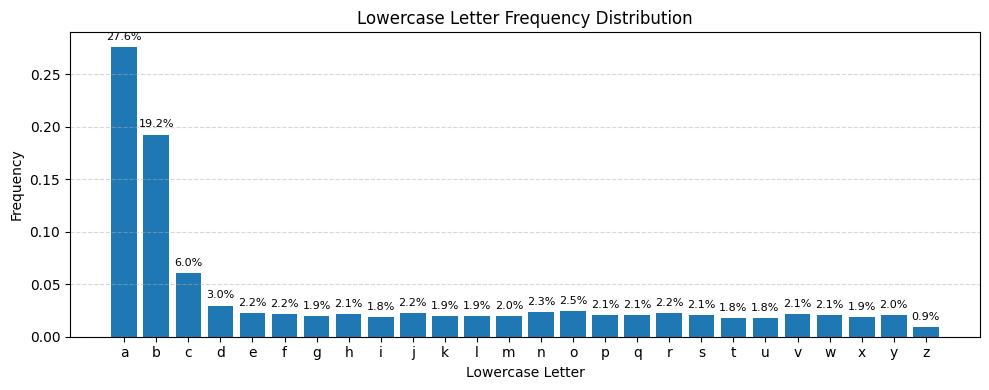

In [14]:
plot_distribution(sample_lower, "Lowercase Letter", num_samples=10000)

In [8]:
def sample_upper():
    letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    n = len(letters)
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=0.0,  # peak at 'A'
        std=18.0,
        tail_smooth='right',
        baseline_weight=0.1,
        suppression_strength=1.5,
        size=1
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    return letters[idx]

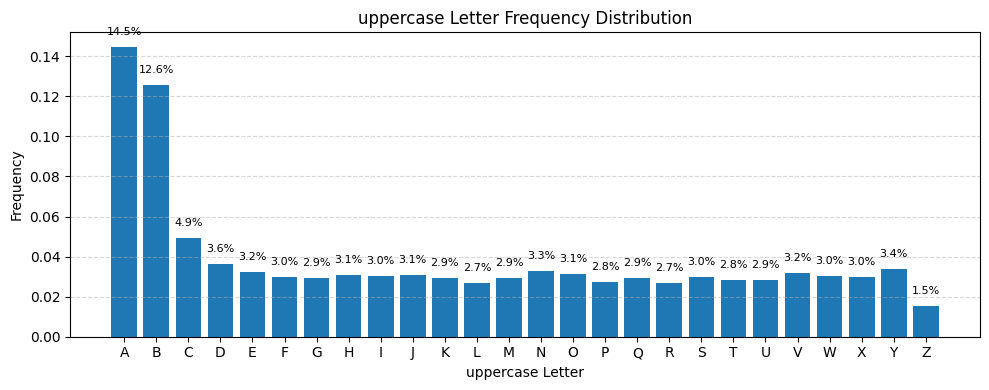

In [16]:
plot_distribution(sample_upper, "uppercase Letter", num_samples=10000)

In [9]:
def sample_length():
    lengths = [1, 2, 3, 4, 5, 6]
    n = len(lengths)
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0, max_val=n-1, mean=0.0, std=2.0,
        tail_smooth='right', baseline_weight=0.1, size=1,
        suppression_strength=1.5,
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    return lengths[idx]

In [10]:
sample_time = 1000
from collections import defaultdict
import time
num_count = defaultdict(int)
for i in range(sample_time):
    gen_l = sample_length()
    # time.sleep(0.1)
    # print(" sample length is: ", gen_l)
    num_count[gen_l] += 1

print(num_count)

defaultdict(<class 'int'>, {1: 420, 2: 338, 3: 99, 5: 61, 4: 54, 6: 28})


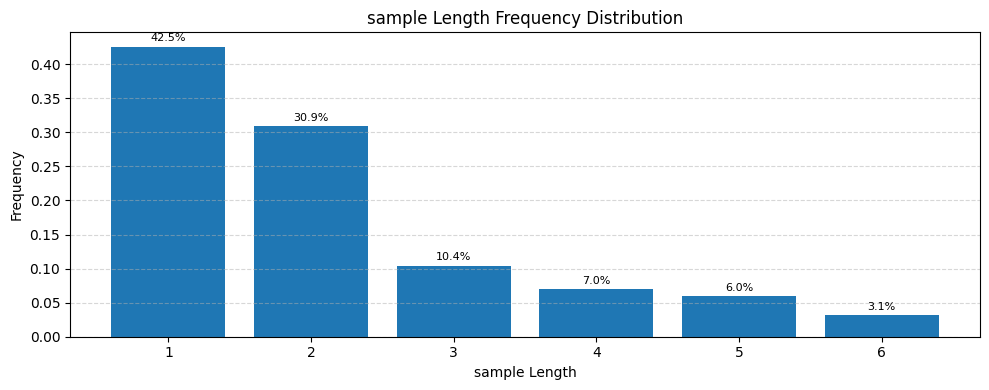

In [19]:
plot_distribution(sample_length, "sample Length", num_samples=10000)

create superscript text

try 4 (best one) (superscript)


[INFO] Generating 1000 superscripts:
  Digits:   300
  Lower:    200
  Upper:    50
  Brackets: 450

[INFO] Bracket styles:
  → ():     360
  → []:     45
  → {}:    45

[INFO] Bracket inner content distribution:
  → Digit-only:    225
  → Lower-only:    202
  → Upper-only:    23

[INFO] Final Distribution Summary:
Digits:     300
Lower:      200
Upper:      50
Brackets:   450
Multi Brackets : 285
multi round brackets : 233
multi square brackets : 28
multi curly brackets : 24
  → ():     360
  → []:     45
  → {}:     45


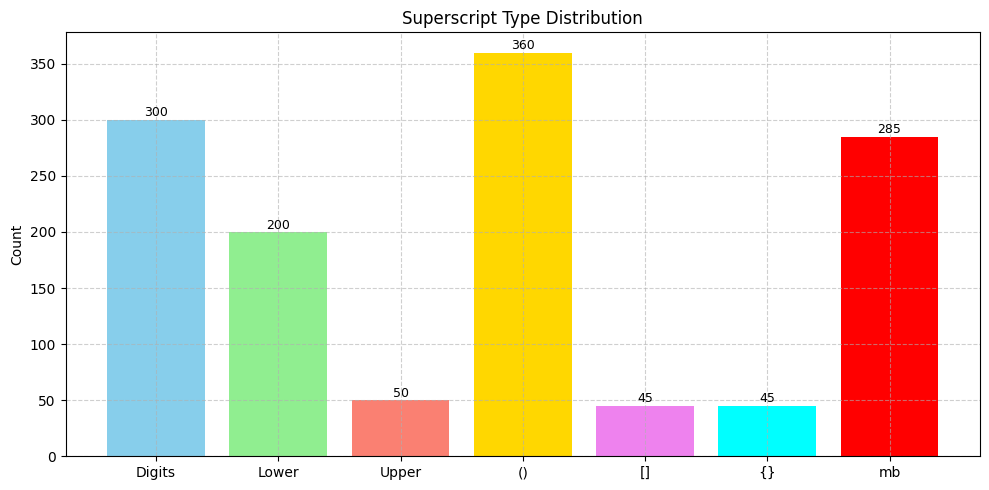


First 10 generated superscripts:
1: 1,5
2: (1)(4)(7)
3: X
4: 1,2
5: 1
6: A,C,G
7: (a,b)
8: p
9: (4)(8)
10: d
11: 3
12: 1
13: [1][2][8]
14: a,c
15: (3)
16: (b)(c)(u)
17: d
18: 2,3
19: 1
20: 2,3
21: 2
22: r,y
23: [w]
24: (m)(t)
25: (3)
26: (2)
27: a,b,c
28: 1,2,3,7
29: (1)(7)
30: (1,2,3,4,6,7)
31: (2)
32: (a,w)
33: (b)
34: [b][e][x]
35: (b)
36: 1
37: (1)(4)(5)
38: 1,2,5
39: \{2\}
40: (b)(q)
41: b
42: B,F,O,U,Y
43: (2)
44: 1,7
45: (x)
46: (1)
47: a
48: (b)
49: (3)(4)(7)
50: (l)
51: a,b,m
52: 2
53: (c)
54: [w]
55: (a)
56: (b)(e)(j)
57: \{h\}\{u\}
58: [1]
59: 1
60: \{2\}\{6\}\{8\}
61: (3)
62: 1,4
63: (1,2,3)
64: [1]
65: (1,2,3,7,8,9)
66: f,s
67: 2
68: (2)
69: 1
70: f,h
71: a,k,y
72: 2
73: v
74: a,b,c,o,q
75: (a,b,c,g,v,x)
76: (1,6)
77: \{1\}\{2\}
78: (2)(9)
79: (1)(2)
80: 1,7
81: a,b,c,w
82: 1,2,3,4,5
83: 1
84: \{o\}
85: 1,2
86: 1
87: \{6\}
88: (a)
89: (1,2,5)
90: \{a,b,f,r\}
91: a,w,x
92: 2
93: u
94: a,b
95: 4
96: 1,2,3,4,5,7
97: a
98: (1,3,7)
99: 1,2
100: 4,6


In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from collections import Counter

np.random.seed(42)
random.seed(42)

digits = list('123456789')
lower_letters = list('abcdefghijklmnopqrstuvwxyz')
upper_letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')


def generate_unique_sorted_content(L, sampler_func):
    seen = set()
    attempts = 0
    while len(seen) < L and attempts < 500:
        ch = sampler_func()
        seen.add(ch)
        attempts += 1

    chars = sorted(seen)
    if len(chars) == 0:
        return ''
    return ','.join(chars[:L])



def generate_superscripts_fixed(num_samples):
    total = num_samples

    # Calculate exact number per type
    num_bracket = round(total * 0.45)
    num_digit   = round(total * 0.30)
    num_lower   = round(total * 0.20)
    num_upper   = total - (num_bracket + num_digit + num_lower)

    print(f"\n[INFO] Generating {total} superscripts:")
    print(f"  Digits:   {num_digit}")
    print(f"  Lower:    {num_lower}")
    print(f"  Upper:    {num_upper}")
    print(f"  Brackets: {num_bracket}")

    # Bracket style breakdown
    bracket_round = round(num_bracket * 0.8)
    bracket_square = max(1, round(num_bracket * 0.1))
    bracket_curly = max(1, num_bracket - bracket_round - bracket_square)

    print(f"\n[INFO] Bracket styles:")
    print(f"  → ():     {bracket_round}")
    print(f"  → []:     {bracket_square}")
    print(f"  → {{}}:    {bracket_curly}")

    # Generate bracket types
    all_brackets = (
        ['Round'] * bracket_round +
        ['Square'] * bracket_square +
        ['Curly'] * bracket_curly
    )
    random.shuffle(all_brackets)
    ######## keep some multibrackets #############
    # num_multi_brackets = round(0.2 * num_bracket)
    # num_single_brackets = num_bracket - num_multi_brackets
    ########################################
    
    # Number of each content type among brackets
    bracket_digits = int(num_bracket * 0.5)
    bracket_lower = int(num_bracket * 0.45)
    bracket_upper = num_bracket - bracket_digits - bracket_lower

    print("\n[INFO] Bracket inner content distribution:")
    print(f"  → Digit-only:    {bracket_digits}")
    print(f"  → Lower-only:    {bracket_lower}")
    print(f"  → Upper-only:    {bracket_upper}")

    # Build lists of content samplers
    bracket_content_samplers = (
        [('digit', sample_digit)] * bracket_digits +
        [('lower', sample_lower)] * bracket_lower +
        [('upper', sample_upper)] * bracket_upper
    )

    random.shuffle(bracket_content_samplers)

    # build bracketed strings
    i = 0
    results = []
    # keep track of counts
    cnt_multi_round = 0
    cnt_multi_square = 0
    cnt_multi_curly = 0
    cnt_mb = 0
    for bt in all_brackets:
        if i >= len(bracket_content_samplers):
            break
        max_group_len=3
        group_len = 1 if random.random() < 0.6 else random.randint(2, max_group_len)
        choose_group = random.choices([True,False], weights=[0.6, 0.4])[0]
        content_type, sampler = bracket_content_samplers[i]
        if choose_group:
            parts= []
            prev_inner = set()
            final_inners = set()
            # prev_inner_val = -1
            for _ in range(group_len):
                L=1
                inner = generate_unique_sorted_content(L, sampler)
                max_attempts= 1000
                attempts = 0
                while inner in prev_inner and attempts < max_attempts:
                    inner = generate_unique_sorted_content(L, sampler)
                    attempts += 1
                if inner in prev_inner:
                    print("Warning: duplicate inner value after max attempts.")
                prev_inner.add(inner)
                final_inners.add(inner)
                # if inner in prev_inner:
                #     i=0
                #     while i < 1000:
                #         inner = generate_unique_sorted_content(L, sampler)
                #         if inner not in prev_inner:
                #             break
                #         i+=1
                #     if i >= 1000:
                #         print("could not find unique inner")
                #     #     inner = prev_inner_val+1 
                # prev_inner.add(inner)
                # prev_inner_val = inner    
                    
                # if bt == 'Round':
                #     part = f'({inner})'
                # elif bt == 'Square':
                #     part = f'[{inner}]'
                # else:
                #     part = "\{" + inner + "\}"
                # parts.append(part)
            sorted_inners = sorted(final_inners)
            
            for inner in sorted_inners:
                if bt == 'Round':
                    part = f'({inner})'
                elif bt == 'Square':
                    part = f'[{inner}]'
                else:
                    part = "\{" + inner + "\}"
                parts.append(part)
                    
            combined = ''.join(parts)
            if bt == "Round":
                cnt_multi_round +=1
                results.append(('()', combined))
            elif bt == "Square":
                cnt_multi_square +=1
                results.append(('[]', combined))
            else:
                cnt_multi_curly +=1
                results.append(('{}', combined))
            
            cnt_mb +=1
            # results.append(('MultiBracket', combined))
        else:
            L = sample_length()
            inner = generate_unique_sorted_content(L, sampler)

            if bt == 'Round':
                # cnt_round +=1
                results.append(('()', f'({inner})'))
            elif bt == 'Square':
                # cnt_square +=1
                results.append(('[]', f'[{inner}]'))
            else:
                # cnt_curly +=1
                inner = "\{" + inner + "\}"
                results.append(('{}', f'{inner}'))

        i += 1

    # Generate non-bracket strings
    for _ in range(num_digit):
        L = sample_length()
        inner = generate_unique_sorted_content(L, sample_digit)
        results.append(('Digit', inner))

    for _ in range(num_lower):
        L = sample_length()
        inner = generate_unique_sorted_content(L, sample_lower)
        results.append(('Lower', inner))

    for _ in range(num_upper):
        L = sample_length()
        inner = generate_unique_sorted_content(L, sample_upper)
        results.append(('Upper', inner))

    # Shuffle final output
    random.shuffle(results)
    
    # Count stats
    stats = {
        'Digit': 0,
        'Lower': 0,
        'Upper': 0,
        'Round': 0,
        'Square': 0,
        'Curly': 0,
        'MultiBracket': 0
    }

    for typ, val in results:
        if typ == '()':
            stats['Round'] += 1
        elif typ == '[]':
            stats['Square'] += 1
        elif typ == '{}':
            stats['Curly'] += 1
        elif typ == 'Digit':
            stats['Digit'] += 1
        elif typ == 'Lower':
            stats['Lower'] += 1
        elif typ == 'Upper':
            stats['Upper'] += 1
        # elif typ == 'MultiBracket': 
        #     stats['MultiBracket'] += 1
    stats['MultiBracket'] = cnt_mb
    print("\n[INFO] Final Distribution Summary:")
    print(f"Digits:     {stats['Digit']}")
    print(f"Lower:      {stats['Lower']}")
    print(f"Upper:      {stats['Upper']}")
    print(f"Brackets:   {stats['Round'] + stats['Square'] + stats['Curly']}")
    # print(f"Brackets:   {cnt_round + cnt_square + cnt_curly}")
    # print(f"Multi Brackets : {stats['MultiBracket']}")
    print(f"Multi Brackets : {cnt_mb}")
    print(f"multi round brackets : {cnt_multi_round}")
    print(f"multi square brackets : {cnt_multi_square}")
    print(f"multi curly brackets : {cnt_multi_curly}")
    print(f"  → ():     {stats['Round']}")
    print(f"  → []:     {stats['Square']}")
    print(f"  → {{}}:     {stats['Curly']}")
    

    # Plotting
    categories = ['Digits', 'Lower', 'Upper', '()', '[]', '{}','mb']
    counts = [
        stats['Digit'],
        stats['Lower'],
        stats['Upper'],
        stats['Round'],
        stats['Square'],
        stats['Curly'],
        stats['MultiBracket']
    ]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(categories, counts, color=['skyblue', 'lightgreen', 'salmon', 'gold', 'violet', 'cyan', 'red'])
    plt.title("Superscript Type Distribution")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.6)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                 str(int(height)), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Return just the string values
    return [val for _, val in results]



if __name__ == '__main__':
    superscripts = generate_superscripts_fixed(1000)

    print("\nFirst 10 generated superscripts:")
    for idx, s in enumerate(superscripts[:100], 1):
        print(f"{idx}: {s}")

Sub script


[INFO] Generating 100 superscripts:
  Digits:   50
  Lower:    30
  Upper:    20

[INFO] Final Distribution Summary:
Digits:     50
Lower:      30
Upper:      20


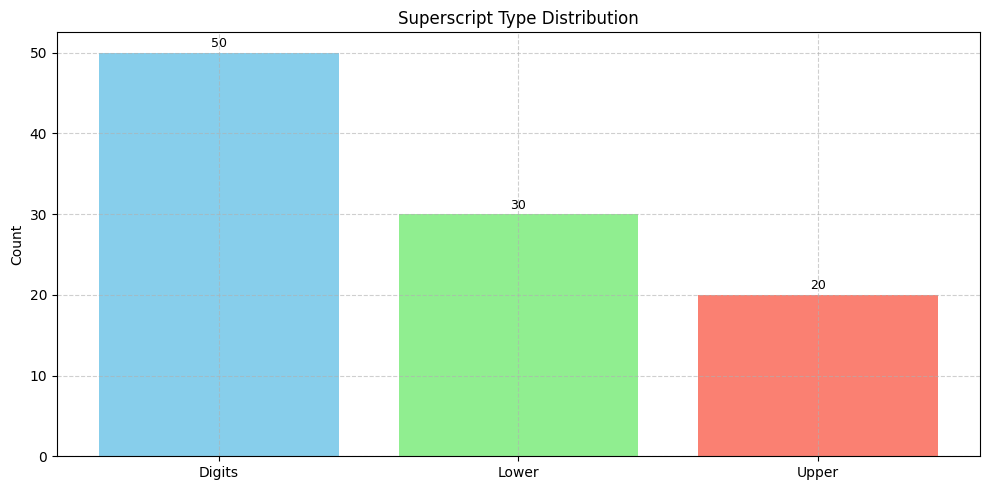


First 10 generated superscripts:
1: 3
2: 2
3: A,P,U
4: 2
5: a,b,d,w
6: a,h,o,u
7: 1,2
8: q
9: 1,2,5,6,9
10: a


In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from collections import Counter

np.random.seed(42)
random.seed(42)

digits = list('123456789')
lower_letters = list('abcdefghijklmnopqrstuvwxyz')
upper_letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')


def generate_unique_sorted_content(L, sampler_func):
    seen = set()
    attempts = 0
    while len(seen) < L and attempts < 100:
        ch = sampler_func()
        seen.add(ch)
        attempts += 1

    chars = sorted(seen)
    if len(chars) == 0:
        return ''
    return ','.join(chars[:L])



def generate_subscript_fixed(num_samples):
    total = num_samples

    # Calculate exact number per type
    # num_bracket = round(total * 0.45)
    num_digit   = round(total * 0.50)
    num_lower   = round(total * 0.30)
    num_upper   = total - (num_digit + num_lower)

    print(f"\n[INFO] Generating {total} superscripts:")
    print(f"  Digits:   {num_digit}")
    print(f"  Lower:    {num_lower}")
    print(f"  Upper:    {num_upper}")
    # print(f"  Brackets: {num_bracket}")
    
    results= []

    # Generate non-bracket strings
    for _ in range(num_digit):
        L = sample_length()
        inner = generate_unique_sorted_content(L, sample_digit)
        results.append(('Digit', inner))

    for _ in range(num_lower):
        L = sample_length()
        inner = generate_unique_sorted_content(L, sample_lower)
        results.append(('Lower', inner))

    for _ in range(num_upper):
        L = sample_length()
        inner = generate_unique_sorted_content(L, sample_upper)
        results.append(('Upper', inner))

    # Shuffle final output
    random.shuffle(results)

    # Count stats
    stats = {
        'Digit': 0,
        'Lower': 0,
        'Upper': 0,
    }

    for typ, val in results:
        if typ == 'Digit':
            stats['Digit'] += 1
        elif typ == 'Lower':
            stats['Lower'] += 1
        elif typ == 'Upper':
            stats['Upper'] += 1

    print("\n[INFO] Final Distribution Summary:")
    print(f"Digits:     {stats['Digit']}")
    print(f"Lower:      {stats['Lower']}")
    print(f"Upper:      {stats['Upper']}")

    # Plotting
    categories = ['Digits', 'Lower', 'Upper']
    counts = [
        stats['Digit'],
        stats['Lower'],
        stats['Upper']
    ]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(categories, counts, color=['skyblue', 'lightgreen', 'salmon'])
    plt.title("Superscript Type Distribution")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.6)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                 str(int(height)), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Return just the string values
    return [val for _, val in results]



subscripts = generate_subscript_fixed(100)

print("\nFirst 10 generated superscripts:")
for idx, s in enumerate(subscripts[:10], 1):
    print(f"{idx}: {s}")

function for random colors and fonts

In [45]:
# def generate_custom_color_category(tail_smooth='left', suppression_strength=1.0,
#                                          baseline_weight=0.05, seed=None):
#     color_categories = {
#         0: ('dark_blue',  {'r': (0, 30),   'g': (0, 30),   'b': (80, 150)}),
#         1: ('black',      {'r': (0, 30),   'g': (0, 30),   'b': (0, 30)})
#     }

#     category_ids = list(color_categories.keys())
#     num_categories = len(category_ids)

#     mean = 1
#     std = 1

#     index_sample = sample_truncnorm_with_tail_and_baseline(
#         min_val=0,
#         max_val=num_categories - 1,
#         mean=mean,
#         std=std,
#         tail_smooth=tail_smooth,
#         suppression_strength=suppression_strength,
#         baseline_weight=baseline_weight,
#         size=1,
#         seed=seed
#     )[0]

#     selected_index = int(round(index_sample))
#     selected_index = max(min(selected_index, num_categories - 1), 0)

#     cat_key = category_ids[selected_index]
#     cat_name, rgb_ranges = color_categories[cat_key]

#     r = int(random.randint(*rgb_ranges['r']))
#     g = int(random.randint(*rgb_ranges['g']))
#     b = int(random.randint(*rgb_ranges['b']))

#     return cat_name, '#{:02x}{:02x}{:02x}{:02x}'.format(r, g, b, 255)
# ####################################################################
# def generate_custom_color_category_2(tail_smooth='left', suppression_strength=1.0,
#                                    baseline_weight=0.05, seed=None):
#     color_categories = {
#         0: ('dark_blue',  {'r': (0, 30),   'g': (0, 30),   'b': (80, 150)}),
#         1: ('black',      {'r': (0, 30),   'g': (0, 30),   'b': (0, 30)}),
#     }

#     category_ids = list(color_categories.keys())
#     num_categories = len(category_ids)

#     mean = 1
#     std = 1

#     index_sample = sample_truncnorm_with_tail_and_baseline(
#         min_val=0,
#         max_val=num_categories - 1,
#         mean=mean,
#         std=std,
#         tail_smooth=tail_smooth,
#         suppression_strength=suppression_strength,
#         baseline_weight=baseline_weight,
#         size=1,
#         seed=seed
#     )[0]

#     selected_index = int(round(index_sample))
#     selected_index = max(min(selected_index, num_categories - 1), 0)

#     cat_key = category_ids[selected_index]
#     cat_name, rgb_ranges = color_categories[cat_key]

#     r = random.randint(*rgb_ranges['r'])
#     g = random.randint(*rgb_ranges['g'])
#     b = random.randint(*rgb_ranges['b'])
#     a = 255  # Full opacity

#     return cat_name, (r, g, b, a)  # Returning tuple (R, G, B, A)


# def sample_font_color():
#     color_categories = {
#         0: ('black',      {'r': (0, 30),   'g': (0, 30),   'b': (0, 30)}),
#         1: ('dark_blue',  {'r': (0, 30),   'g': (0, 30),   'b': (80, 150)}),
#         2: ('dark_gray', {'r': (50, 100),   'g': (50, 100),   'b': (50, 100)}),
#         3: ('dark_green', {'r': (0, 30),   'g': (60, 100),   'b': (0, 30)}),
#         4: ('red', {'r': (200, 255),   'g': (0, 40),   'b': (0, 40)}),
#         5: ('blue', {'r': (0, 100),   'g': (0, 100),   'b': (180, 255)}),
#         6: ('purple', {'r': (100, 200),   'g': (0, 120),   'b': (120, 225)}),
#         7: ('yellow', {'r': (200, 255),   'g': (180, 255),   'b': (0, 100)}),
#     }
    
#     category_ids = list(color_categories.keys())
#     num_categories = len(category_ids)

#     mean = 0
#     std = 3

#     index_sample = sample_truncnorm_with_tail_and_baseline(
#         min_val=0,
#         max_val=num_categories - 1,
#         mean=mean,  # peak at 'black'
#         std=std,
#         tail_smooth='right',
#         baseline_weight=0.1,
#         suppression_strength=1.5,
#         size=1
#     )[0]

#     selected_index = int(round(index_sample))
#     selected_index = max(min(selected_index, num_categories - 1), 0)

#     cat_key = category_ids[selected_index]
#     cat_name, rgb_ranges = color_categories[cat_key]

#     r = random.randint(*rgb_ranges['r'])
#     g = random.randint(*rgb_ranges['g'])
#     b = random.randint(*rgb_ranges['b'])
#     a = 255  # Full opacity

#     return cat_name, (r, g, b, a)  # Returning tuple (R, G, B, A)


# #####################################################################
# def plot_color_category_distribution(tail_smooth='left', suppression_strength=0.8, baseline_weight=0.1, seed=42):
#     color_categories = {
#         0: 'dark_blue',
#         1: 'black'
#     }

#     min_val = 0
#     max_val = len(color_categories) - 1
#     mean = 1
#     std = 1

#     samples, x, pdf = sample_truncnorm_with_tail_and_baseline(
#         min_val=min_val,
#         max_val=max_val,
#         mean=mean,
#         std=std,
#         tail_smooth=tail_smooth,
#         suppression_strength=suppression_strength,
#         baseline_weight=baseline_weight,
#         size=100000,
#         return_pdf=True,
#         seed=seed
#     )

#     bin_edges = np.arange(min_val - 0.5, max_val + 1.5, 1)
#     plt.figure(figsize=(10, 8))
#     plt.hist(samples, bins=bin_edges, density=True, alpha=0.6, color='skyblue', label='Sampled Category Distribution')
#     # plt.plot(x, pdf, 'r-', lw=2, label='Sampling PDF')
#     plt.xticks(list(color_categories.keys()), [color_categories[i] for i in color_categories])
#     plt.xlabel("Color Categories")
#     plt.ylabel("Probability Density")
#     plt.title("Truncated Normal Sampling over Color Categories")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()




Add new sample_font_color and plot_color_category_distribution_upd

In [13]:
def sample_font_color():
    color_categories = {
        0: ('black',      {'r': (0, 30),   'g': (0, 30),   'b': (0, 30)}),
        1: ('dark_blue',  {'r': (0, 30),   'g': (0, 30),   'b': (80, 150)}),
        2: ('dark_gray', {'r': (50, 100),   'g': (50, 100),   'b': (50, 100)}),
        3: ('dark_green', {'r': (0, 30),   'g': (60, 100),   'b': (0, 30)}),
        4: ('red', {'r': (200, 255),   'g': (0, 40),   'b': (0, 40)}),
        5: ('blue', {'r': (0, 100),   'g': (0, 100),   'b': (180, 255)}),
        6: ('purple', {'r': (100, 200),   'g': (0, 120),   'b': (120, 225)}),
        7: ('yellow', {'r': (200, 255),   'g': (180, 255),   'b': (0, 100)}),
    }
    
    category_ids = list(color_categories.keys())
    num_categories = len(category_ids)

    mean = 0
    std = 2

    index_sample = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=num_categories - 1,
        mean=mean,  # peak at 'black'
        std=std,
        tail_smooth='right',
        baseline_weight=0.1,
        suppression_strength=1.0,
        size=1
    )[0]

    selected_index = int(round(index_sample))
    selected_index = max(min(selected_index, num_categories - 1), 0)

    cat_key = category_ids[selected_index]
    cat_name, rgb_ranges = color_categories[cat_key]

    r = random.randint(*rgb_ranges['r'])
    g = random.randint(*rgb_ranges['g'])
    b = random.randint(*rgb_ranges['b'])
    a = 255  # Full opacity

    return cat_name, (r, g, b, a)  # Returning tuple (R, G, B, A)

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_color_category_distribution(sampler_func, categories, num_samples=1000):
    """
    Plots a horizontal bar chart of color category frequencies sampled from `sampler_func`.

    Parameters:
    - sampler_func: A function returning (category_name, (r, g, b, a))
    - categories: List or dict of categories (e.g., {id: (name, ...)} or [name, ...])
    - num_samples: How many samples to draw
    """
    # Extract category names
    # Get category names
    if isinstance(categories, dict):
        category_names = [categories[i][0] for i in sorted(categories.keys())]
    else:
        category_names = list(categories)

    # Sample the function
    sampled_names = [sampler_func()[0] for _ in range(num_samples)]
    counts = Counter(sampled_names)
    frequencies = [counts.get(name, 0) for name in category_names]

    # Plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(category_names, frequencies, color='cornflowerblue', edgecolor='black')

    # Add frequency labels on top of each bar
    for bar, freq in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(freq),
                 ha='center', va='bottom', fontsize=9)

    plt.title(f"Color Category Distribution over {num_samples} Samples")
    plt.xlabel("Color Category")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


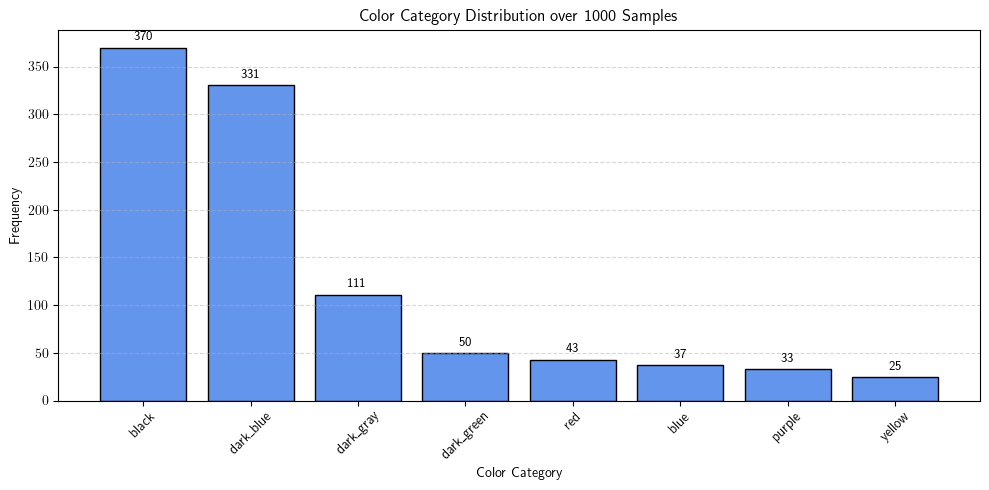

In [148]:
color_categories = {
    0: ('black',      {'r': (0, 30),   'g': (0, 30),   'b': (0, 30)}),
    1: ('dark_blue',  {'r': (0, 30),   'g': (0, 30),   'b': (80, 150)}),
    2: ('dark_gray', {'r': (50, 100),   'g': (50, 100),   'b': (50, 100)}),
    3: ('dark_green', {'r': (0, 30),   'g': (60, 100),   'b': (0, 30)}),
    4: ('red', {'r': (200, 255),   'g': (0, 40),   'b': (0, 40)}),
    5: ('blue', {'r': (0, 100),   'g': (0, 100),   'b': (180, 255)}),
    6: ('purple', {'r': (100, 200),   'g': (0, 120),   'b': (120, 225)}),
    7: ('yellow', {'r': (200, 255),   'g': (180, 255),   'b': (0, 100)}),
}
    

plot_color_category_distribution(sample_font_color, color_categories, num_samples=1000)

function for font size

In [15]:
def sample_font_size():
    digits = list(range(3, 21))
    n = len(digits)
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=2,  # peak at '1'
        std=3.0,
        tail_smooth='both',
        baseline_weight=0.2,
        suppression_strength=0.2,
        size=1,
        return_pdf = False
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    return digits[idx]

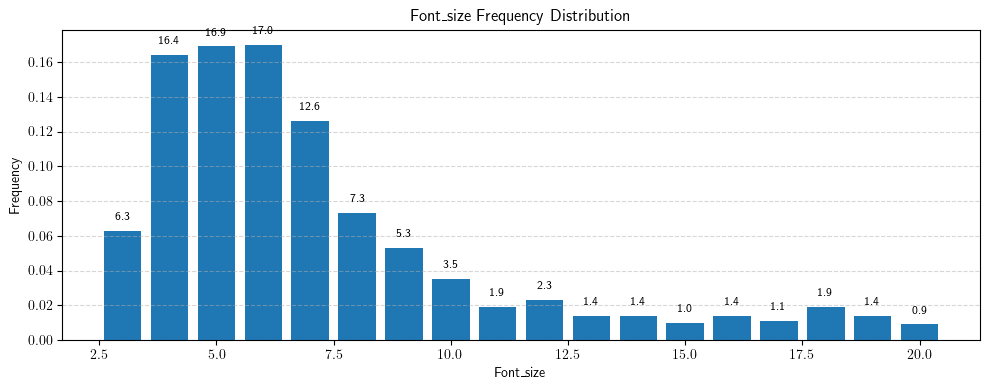

In [150]:
plot_distribution(sample_font_size, "Font_size", num_samples=1000)

for background color

In [16]:
def sample_background_color():
    color_categories = {
        0: ("white",        {'r': (245, 255),'g': (245, 255),'b': (240, 255)}),
        1: ("light_gray", {'r': (210, 240), 'g': (210, 240), 'b': (210, 240)}),
        2: ("light_blue", {'r': (180, 205), 'g': (200, 230), 'b': (230, 255)}),
        3: ("light_yellow", {'r': (230, 255), 'g': (230, 255), 'b': (170, 2000)}),
        4: ("light_red", {'r': (220, 255), 'g': (120, 150), 'b': (120, 150)}),
    }
    
    category_ids = list(color_categories.keys())
    num_categories = len(category_ids)

    mean = 0
    std = 1
    index_sample = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=num_categories - 1,
        mean=mean,  # peak at 'black'
        std=std,
        tail_smooth='right',
        baseline_weight=0.1,
        suppression_strength=1.9,
        size=1
    )[0]

    selected_index = int(round(index_sample))
    selected_index = max(min(selected_index, num_categories - 1), 0)

    cat_key = category_ids[selected_index]
    cat_name, rgb_ranges = color_categories[cat_key]

    r = random.randint(*rgb_ranges['r'])
    g = random.randint(*rgb_ranges['g'])
    b = random.randint(*rgb_ranges['b'])
    a = 255  # Full opacity

    return cat_name, (r, g, b, a)  # Returning tuple (R, G, B, A)

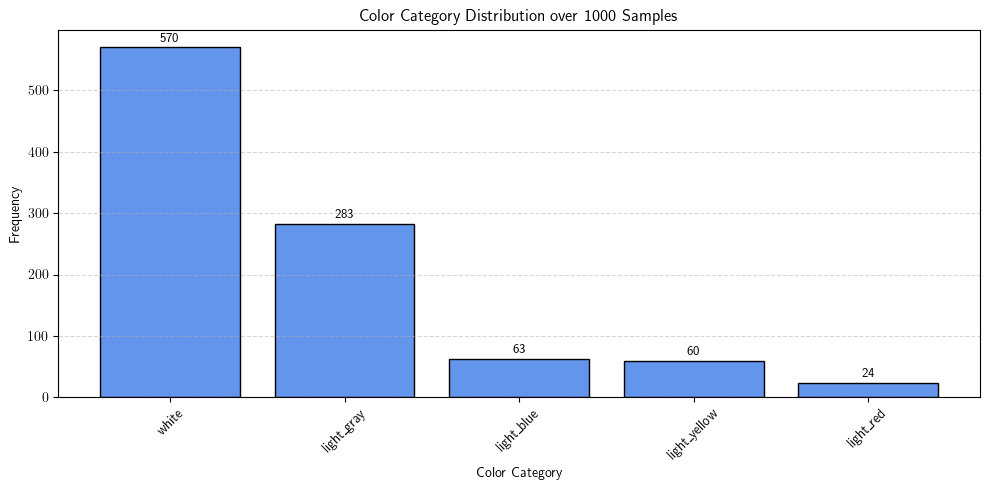

In [152]:
color_categories = {
    0: ("white",        {'r': (245, 255),'g': (245, 255),'b': (240, 255)}),
    1: ("light_gray", {'r': (210, 240), 'g': (210, 240), 'b': (210, 240)}),
    2: ("light_blue", {'r': (180, 205), 'g': (200, 230), 'b': (230, 255)}),
    3: ("light_yellow", {'r': (230, 255), 'g': (230, 255), 'b': (170, 2000)}),
    4: ("light_red", {'r': (220, 255), 'g': (120, 150), 'b': (120, 150)}),
}
plot_color_category_distribution(sample_background_color, color_categories, num_samples=1000)

Add sample function for super_sub_position

In [17]:
def sample_super_sub_position_v1():
    fixed_ratios = [-0.5, -0.4, -0.3, -0.2, 0]
    fixed_ratios = list(range(len(fixed_ratios)))
    n = len(fixed_ratios)
    
    add_varies = random.randint(-2, 2) / 100
    
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=1,  # peak at 'a'
        std=4,
        tail_smooth='both',
        baseline_weight=0.8,
        suppression_strength=0,
        size=1
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    varied_value = fixed_ratios[idx] + add_varies
    if varied_value > 1:
        varied_value = 1
    return fixed_ratios[idx]

def sample_super_sub_position():
    fixed_ratios = [-0.5, -0.4, -0.3, -0.2, 0]
    n = len(fixed_ratios)
    
    add_varies = random.randint(-2, 2) / 100
    print("add_varies: ", add_varies)
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=1,  # peak at 'a'
        std=4,
        tail_smooth='both',
        baseline_weight=0.8,
        suppression_strength=0,
        size=1
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    varied_value = fixed_ratios[idx] + add_varies
    if varied_value > 1:
        varied_value = 1
    return varied_value

In [41]:
for _ in range(20):
    print(sample_super_sub_position())

add_varies:  -0.02
-0.42000000000000004
add_varies:  0.02
-0.38
add_varies:  -0.01
-0.21000000000000002
add_varies:  0.01
0.01
add_varies:  0.01
-0.39
add_varies:  -0.02
-0.22
add_varies:  -0.02
-0.52
add_varies:  -0.02
-0.42000000000000004
add_varies:  0.0
-0.5
add_varies:  -0.02
-0.42000000000000004
add_varies:  0.02
0.02
add_varies:  -0.02
-0.32
add_varies:  -0.02
-0.52
add_varies:  -0.01
-0.01
add_varies:  0.02
0.02
add_varies:  -0.02
-0.22
add_varies:  0.01
0.01
add_varies:  0.02
-0.38
add_varies:  0.02
-0.18000000000000002
add_varies:  0.0
-0.2


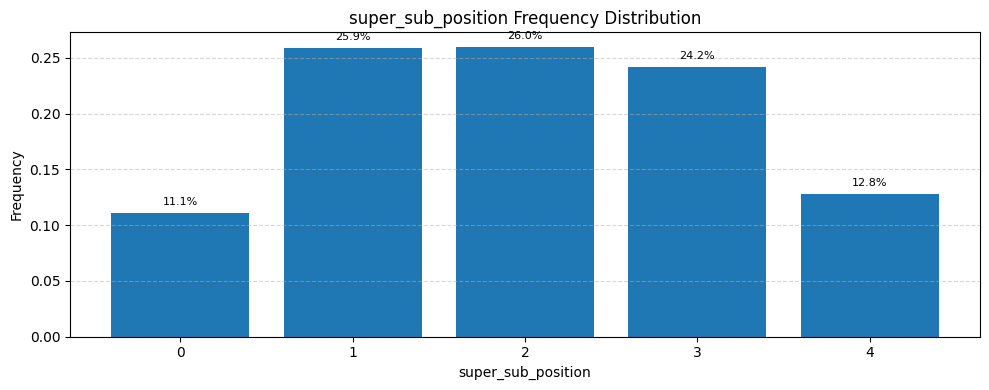

In [59]:
plot_distribution(sample_super_sub_position_v1, "super_sub_position", num_samples=1000)

Add sample function for superscript and subscript / main_text ratio

In [18]:
def sample_super_sub_main_text_ratio_v1():
    fixed_ratios = [0.25, 0.3, 0.38, 0.55, 0.7]
    fixed_ratios = list(range(len(fixed_ratios)))
    n = len(fixed_ratios)
    
    add_varies = random.randint(-8, 10) / 100
    
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=3,  # peak at 'a'
        std=7,
        tail_smooth='both',
        baseline_weight=0.3,
        suppression_strength=0,
        size=1
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    varied_value = fixed_ratios[idx] + add_varies
    if varied_value > 1:
        varied_value = 1
    return fixed_ratios[idx]

def sample_super_sub_main_text_ratio():
    fixed_ratios = [0.35, 0.4, 0.48, 0.65, 0.75]
    n = len(fixed_ratios)
    
    add_varies = random.randint(-8, 10) / 100
    print("add_varies: ", add_varies)
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=3,  # peak at 'a'
        std=7,
        tail_smooth='both',
        baseline_weight=0.3,
        suppression_strength=0,
        size=1
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    varied_value = fixed_ratios[idx] + add_varies
    if varied_value > 1:
        varied_value = 1
    return varied_value

import pandas as pd

def read_supersubscript_pos_ratio_map(font_type):
    map_file_folder = "/app/super_sub_script_1/data_creation_1/font_type_superscript_pos_ratio_map_May_21_2025"
    all_map_font = [x.replace(".csv", "") for x in os.listdir(map_file_folder) if x.endswith('.csv')]
    sel_font = [x for x in all_map_font if x.lower() in font_type.lower()]
    if len(sel_font) == 1:
        # get the font_map_ratio
        sel_font = sel_font[0] + ".csv"
        font_df = pd.read_csv(os.path.join(map_file_folder, sel_font), sep="\t")
        return font_df
    else:
        return pd.DataFrame()

def sample_super_sub_main_text_ratio_ft(super_pos, font_size, font_type):
    
    map_df = read_supersubscript_pos_ratio_map(font_type)
    
    if map_df.empty:
        print("can't find he map dictionary for this font type")
        return None
    else:
        print("Find the map dictionary")
        
    map_key = round(super_pos,1)
    if map_key > -0.1:
        map_key = 0
    
    row_map_index = map_df['vertical_pos'].values.tolist().index(map_key)
    map_col_name = "font_size_" + str(font_size)
    print(" ===: mapping font size is: ", font_size)
    deduct_para = 0
    if map_col_name not in map_df.columns.values.tolist():
        if font_size < 6:
            # font_size = 5 will take the same parameters as font 6
            # for font_size 3, 4, will reduce the font_6 parameter by 0.02
            if font_size < 5:
                deduct_para = -0.02
            
            font_size = 6
            map_col_name = "font_size_" + str(font_size)
            map_ratio = float(map_df[map_col_name].iloc[row_map_index]) - deduct_para
            
        else:
            map_col_plus = "font_size_" + str(font_size + 1) 
            map_col_minus = "font_size_" + str(font_size- 1)
            map_plus_ratio = float(map_df[map_col_plus].iloc[row_map_index])
            map_minus_ratio = float(map_df[map_col_minus].iloc[row_map_index])
            map_ratio = (map_plus_ratio + map_minus_ratio) / 2
    else:
        map_ratio = float(map_df[map_col_name].iloc[row_map_index]) - deduct_para
    
    add_diff = np.random.randint(10, 15)/100
    return map_ratio + add_diff


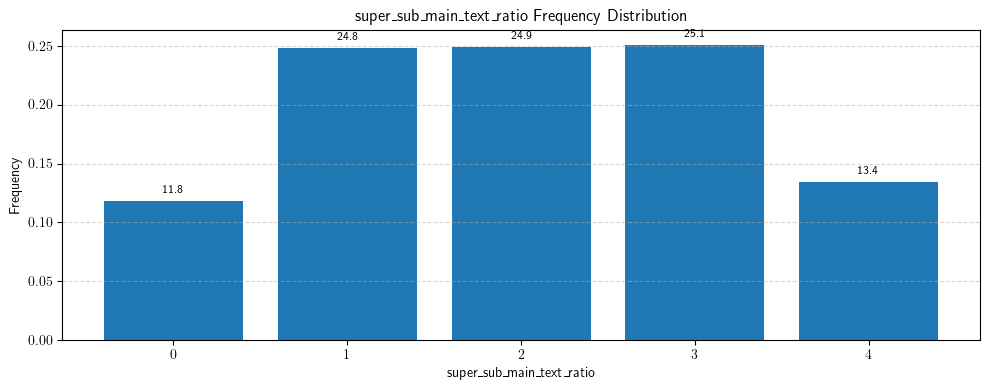

In [101]:
plot_distribution(sample_super_sub_main_text_ratio_v1, "super_sub_main_text_ratio", num_samples=1000)

In [57]:
for _ in range(20):
    print(sample_super_sub_main_text_ratio())


add_varies:  0.1
0.75
add_varies:  0.03
0.43000000000000005
add_varies:  -0.04
0.44
add_varies:  0.02
0.37
add_varies:  0.04
0.44
add_varies:  0.1
0.75
add_varies:  -0.08
0.5700000000000001
add_varies:  0.01
0.41000000000000003
add_varies:  -0.07
0.33
add_varies:  0.1
0.5
add_varies:  0.09
0.43999999999999995
add_varies:  -0.02
0.73
add_varies:  0.04
0.6900000000000001
add_varies:  0.05
0.53
add_varies:  0.02
0.67
add_varies:  0.03
0.68
add_varies:  -0.04
0.61
add_varies:  0.08
0.43
add_varies:  0.1
0.5
add_varies:  -0.01
0.64


Define the function for select the value based on the ratio

In [19]:
def sample_by_ratio(numbs, ratio):
    pass


def sample_by_precentage(percentage_True):
    # return percentage that is true
    # 10 percentage that is True
    threshold = 100 - percentage_True
    if np.random.randint(1, 100 + 1) > threshold:
        return True
    else:
        return False

function to genrate superscript and sunscript with main text

In [20]:
import random
import math

def generate_text_combinations_by_percentage(main_words_file, get_superscripts, get_subscripts, superscript_percentage):
    with open(main_words_file, 'r', encoding='utf-8') as f:
        main_words = sorted([line.strip() for line in f if line.strip()])

    total_words = len(main_words)
    if total_words == 0:
        raise ValueError("No valid main words found in the file.")

    n_superscripts = math.floor(total_words * superscript_percentage)
    n_subscripts = total_words - n_superscripts

    # Randomize main words to mix assignment
    random.shuffle(main_words)
    supers_words = main_words[:n_superscripts]
    subs_words = main_words[n_superscripts:]

    # Get modifier lists
    superscripts = get_superscripts(n_superscripts)
    subscripts = get_subscripts(n_subscripts)

    result = []
    result2 = []

    for word, sup in zip(supers_words, superscripts):
        result.append(f"{word}~{sup}")
        result2.append((word,sup,"super"))

    for word, sub in zip(subs_words, subscripts):
        result.append(f"{word}_{sub}")
        result2.append((word,sub,"sub"))
 
    return result , result2


######################## add for both super and subscript
import random
import math

def generate_whole_text_by_percentage(main_words_file, get_superscripts, get_subscripts, super_percentage, sub_percentage):
    with open(main_words_file, 'r', encoding='utf-8') as f:
        main_words = sorted([line.strip() for line in f if line.strip()])

    total_words = len(main_words)
    if total_words == 0:
        raise ValueError("No valid main words found in the file.")

    n_superscripts = math.floor(total_words * super_percentage)
    n_subscripts = math.floor(total_words * sub_percentage)
    n_super_subscripts = total_words - n_superscripts - n_subscripts

    # Randomize main words to mix assignment
    random.shuffle(main_words)
    supers_words = main_words[:n_superscripts]
    subs_words = main_words[n_superscripts:n_superscripts + n_subscripts]
    supers_subs_words = main_words[n_superscripts + n_subscripts:]

    # Get modifier lists
    superscripts = get_superscripts(n_superscripts)
    subscripts = get_subscripts(n_subscripts)
    both_superscripts, both_subscripts = get_superscripts(n_super_subscripts), get_subscripts(n_super_subscripts)

    result = []
    result2 = []

    for word, sup in zip(supers_words, superscripts):
        result.append(f"{word}~{sup}")
        result2.append((word,sup,"super"))

    for word, sub in zip(subs_words, subscripts):
        result.append(f"{word}_{sub}")
        result2.append((word,sub,"sub"))

    for word, sup, sub in zip(supers_subs_words, both_superscripts, both_subscripts):
        result.append(f"{word}_{sub}~{sup}")
        result2.append((word, sub, sup, "subsuper"))
    return result , result2




Add changes to Tairen latest code

In [26]:


def run_generation_final(
    main_words_file,
    num_of_img_per_font=20,
    output_folder="./outputs2/output_1",
    output_label="./outputs2/",
    font_folder="./fonts",
    background_folder="./img",
    superscript_percentage = 0.85,
    subscript_percentage = 0.1
):
    os.makedirs(output_folder, exist_ok=True)
    
    fonts = [f for f in os.listdir(font_folder) if f.endswith('.ttf')]
    
    if os.path.isdir(background_folder):
        backgrounds = [f for f in os.listdir(background_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    else:
        print(" The text background color should be mentioned")
        sys.exit()
    
    _, gen_whole_words = generate_whole_text_by_percentage(main_words_file, 
                                                           generate_superscripts_fixed, 
                                                           generate_subscript_fixed, 
                                                           superscript_percentage, 
                                                           subscript_percentage)

    save_annotations_file = os.path.join(output_label, "label.txt")
    
    for font_file in fonts:
        num_img_per_font_count = 0
        font_path = os.path.join(font_folder, font_file)
        
        # to avoid repeating the generated words
        random.shuffle(gen_whole_words)
        try:
            for gen_word in gen_whole_words:
                gen_type = gen_word[-1]
                # loop over texts
                if gen_type == "super":
                    main_text, sup_script = gen_word[:2]
                    sub_script = None
                    add_text = f"{main_text}`{sup_script}"
                elif gen_type == "sub":
                    main_text, sub_script = gen_word[:2]
                    sup_script = None
                    add_text = f"{main_text}_{sub_script}"
                else:
                    main_text, sub_script, sup_script = gen_word[:3]
                    add_text = f"{main_text}_{sub_script}`{sup_script}"
                
                gen_font_size = sample_font_size()
                
                pad_all=[np.random.randint(0, 4), np.random.randint(0, 4), np.random.randint(0, 4), np.random.randint(0, 4)]
                
                percentage_use_bkground = 10
                use_image_bg = sample_by_precentage(percentage_use_bkground) # whether to use background images or not
            
                num_img_per_font_count += 1
                
                font_color_category, generated_text_color = sample_font_color()
                
                super_sub_position = sample_super_sub_position()
                
                ## For generating the flatting the superscript purpose:
                super_sub_size_ratio = sample_super_sub_main_text_ratio_ft(super_sub_position, gen_font_size, font_file)
                # super_sub_size_ratio = sample_super_sub_main_text_ratio()
                
                
                if use_image_bg:
                    bg_file = random.choice(backgrounds)
                    current_bg_path = os.path.join(background_folder, bg_file)
                    bg_name = "bg_img_" + os.path.splitext(bg_file)[0]
                    gen_bg_color_arg = None
                    text_color_for_overlay = generated_text_color
                    text_color_for_generate = generated_text_color
                else:
                    backg_color_category, background_color = sample_background_color()
                    
                    adjusted_text_color, adjusted_bg_color, new_ctr = ensure_readable_colors(
                        generated_text_color, background_color)

                    current_bg_path = None
                    gen_bg_color_arg = adjusted_bg_color
                    text_color_for_overlay = adjusted_text_color
                    text_color_for_generate = adjusted_text_color
                    bg_name = f"solid_{backg_color_category}"
                    
                name_base = f"{bg_name}_{os.path.splitext(font_file)[0]}"
                text_color_normalized = normalize_rgba(text_color_for_generate)
                
                # for synthetic image generating
                text_size, gen_image, super_or_sub = generate_text_image(
                    main_text=main_text,
                    super_text=sup_script,
                    sub_text=sub_script,
                    text_color=text_color_normalized,
                    super_sub_position=super_sub_position,
                    super_sub_size=gen_font_size * super_sub_size_ratio,
                    font_size=gen_font_size,
                    font_type=font_path,
                )
                
                if super_or_sub == 0:
                    type = "super"
                elif super_or_sub == 1:
                    type = "sub"
                else:
                    type = "supersub"
                
                
                # remove the "\" in "\{" and "\}"
                if sup_script is not None:
                    if "{" in sup_script or "}" in sup_script:
                        upd_supscript = sup_script.replace("\{", "{").replace("\}", "}")
                    else:
                        upd_supscript = sup_script
                else:
                    upd_supscript = sup_script
                
                if sub_script is not None:
                    if "{" in sub_script or "}" in sub_script:
                        upd_subscript = sub_script.replace("\{", "{").replace("\}", "}")
                    else:
                        upd_subscript = sub_script
                else:
                    upd_subscript = sub_script
                
                save_image_name = f"{name_base}_{gen_font_size}sz_{type}_{main_text}_{upd_supscript}_{upd_subscript}.png"
                
                # save to image folder
                add_image_folder = os.path.join(output_folder, 'image')
                os.makedirs(add_image_folder, exist_ok=True)
                
                final_sup_path = os.path.join(add_image_folder, save_image_name)

                if "{" in add_text or "}" in add_text:
                    add_text = add_text.replace("\{", "{").replace("\}", "}")

                with open(save_annotations_file, "a") as wfile:
                    wfile.write("\t".join([final_sup_path, add_text]) + "\n")
                
                overlay_on_background(
                    gen_image,
                    final_sup_path,
                    text_color_for_overlay,
                    current_bg_path,
                    gen_bg_color_arg,
                    pad_all=pad_all
                )
                
                if num_img_per_font_count == num_of_img_per_font:
                    break
        except:
            print(" !!!!!!! --------------------->  exception happend due to plot error")
            num_img_per_font_count -= 1


For fine-tune the superscript purose

Creating the train dataset


[INFO] Generating 5100 superscripts:
  Digits:   1530
  Lower:    1020
  Upper:    255
  Brackets: 2295

[INFO] Bracket styles:
  → ():     1836
  → []:     230
  → {}:    229

[INFO] Bracket inner content distribution:
  → Digit-only:    1147
  → Lower-only:    1032
  → Upper-only:    116



[INFO] Final Distribution Summary:
Digits:     1530
Lower:      1020
Upper:      255
Brackets:   2295
Multi Brackets : 1383
multi round brackets : 1101
multi square brackets : 143
multi curly brackets : 139
  → ():     1836
  → []:     230
  → {}:     229


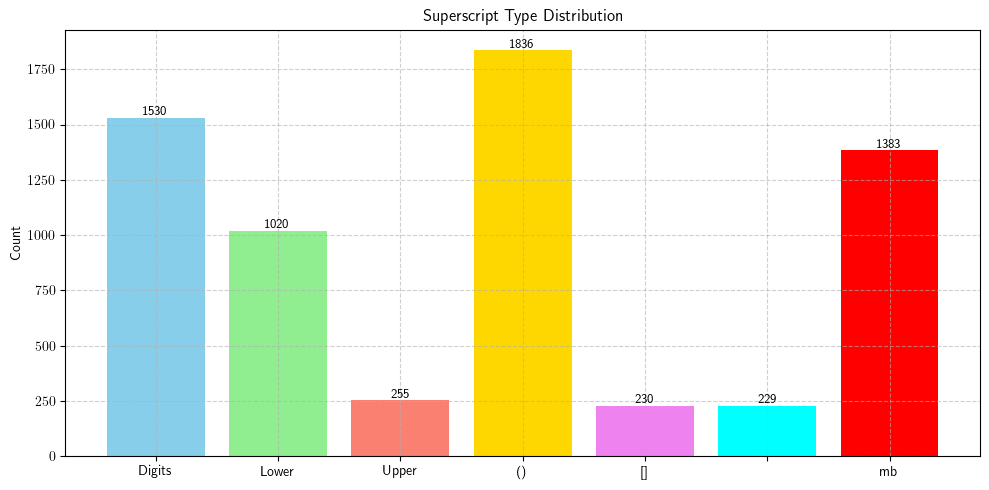


[INFO] Generating 600 superscripts:
  Digits:   300
  Lower:    180
  Upper:    120

[INFO] Final Distribution Summary:
Digits:     300
Lower:      180
Upper:      120


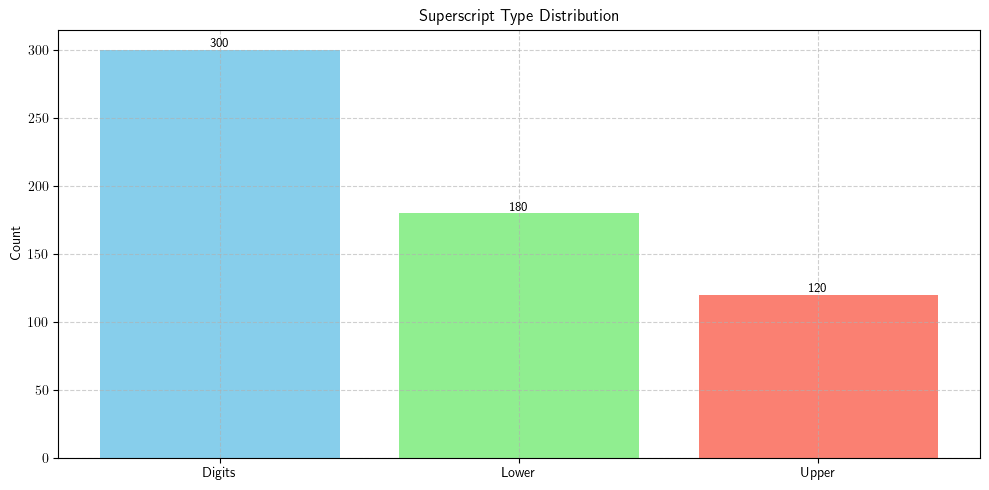


[INFO] Generating 300 superscripts:
  Digits:   90
  Lower:    60
  Upper:    15
  Brackets: 135

[INFO] Bracket styles:
  → ():     108
  → []:     14
  → {}:    13

[INFO] Bracket inner content distribution:
  → Digit-only:    67
  → Lower-only:    60
  → Upper-only:    8

[INFO] Final Distribution Summary:
Digits:     90
Lower:      60
Upper:      15
Brackets:   135
Multi Brackets : 83
multi round brackets : 66
multi square brackets : 8
multi curly brackets : 9
  → ():     108
  → []:     14
  → {}:     13


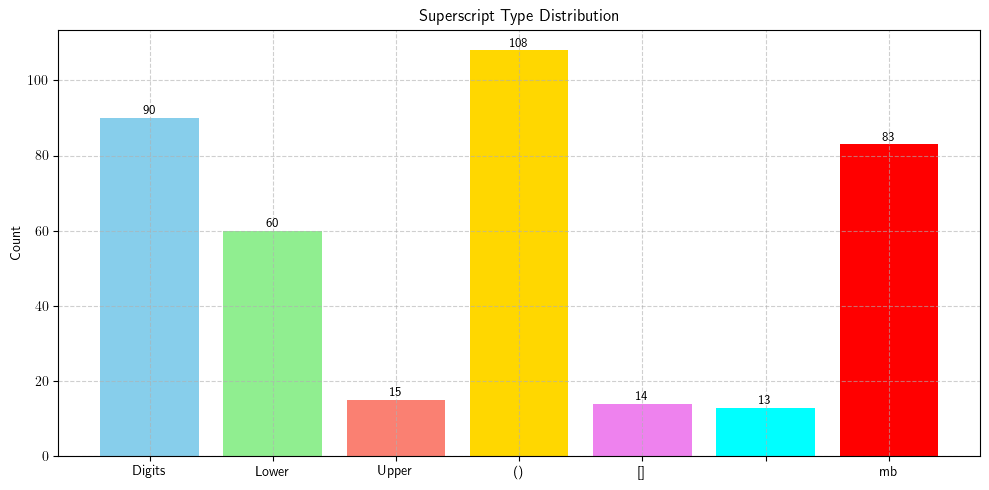


[INFO] Generating 300 superscripts:
  Digits:   150
  Lower:    90
  Upper:    60

[INFO] Final Distribution Summary:
Digits:     150
Lower:      90
Upper:      60


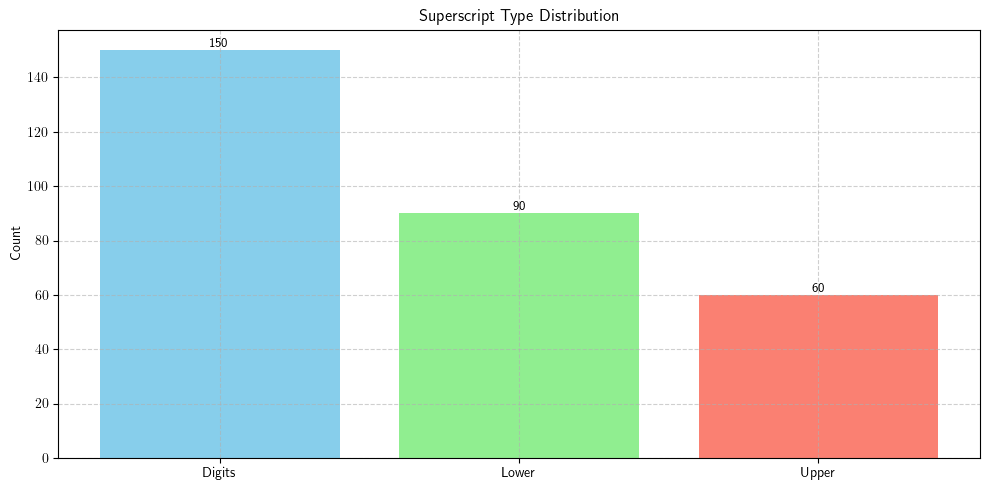

add_varies:  -0.02
Find the map dictionary
 ===: mapping font size is:  5
Combined image saved to ./outputs_TR/train_final_ft/image/solid_white_NotoSans-Regular_5sz_super_45.19_2,4,6_None.png
add_varies:  0.0
Find the map dictionary
 ===: mapping font size is:  15
Combined image saved to ./outputs_TR/train_final_ft/image/solid_white_NotoSans-Regular_15sz_super_015_4_None.png
add_varies:  -0.02
Find the map dictionary
 ===: mapping font size is:  5
Combined image saved to ./outputs_TR/train_final_ft/image/solid_white_NotoSans-Regular_5sz_sub_8:38_None_J,Q.png
add_varies:  0.02
Find the map dictionary
 ===: mapping font size is:  7
Combined image saved to ./outputs_TR/train_final_ft/image/solid_white_NotoSans-Regular_7sz_super_103,909_Y_None.png
add_varies:  0.02
Find the map dictionary
 ===: mapping font size is:  3
Combined image saved to ./outputs_TR/train_final_ft/image/solid_white_NotoSans-Regular_3sz_super_66,979,543_(b)(c)(f)_None.png
add_varies:  -0.01
Find the map dictionary
 ==

In [29]:
main_words_file  = "./data_1/train_2_TR_ft/train_main_text.txt"
run_generation_final(    
    main_words_file,
    num_of_img_per_font=70,
    output_folder="./outputs_TR/train_final_ft/",
    output_label="./outputs_TR/train_final_ft/",
    font_folder="../fonts",
    background_folder="../img_dir")

Creating the test dataset


[INFO] Generating 510 superscripts:
  Digits:   153
  Lower:    102
  Upper:    25
  Brackets: 230

[INFO] Bracket styles:
  → ():     184
  → []:     23
  → {}:    23

[INFO] Bracket inner content distribution:
  → Digit-only:    115
  → Lower-only:    103
  → Upper-only:    12

[INFO] Final Distribution Summary:
Digits:     153
Lower:      102
Upper:      25
Brackets:   230
Multi Brackets : 145
multi round brackets : 117
multi square brackets : 11
multi curly brackets : 17
  → ():     184
  → []:     23
  → {}:     23


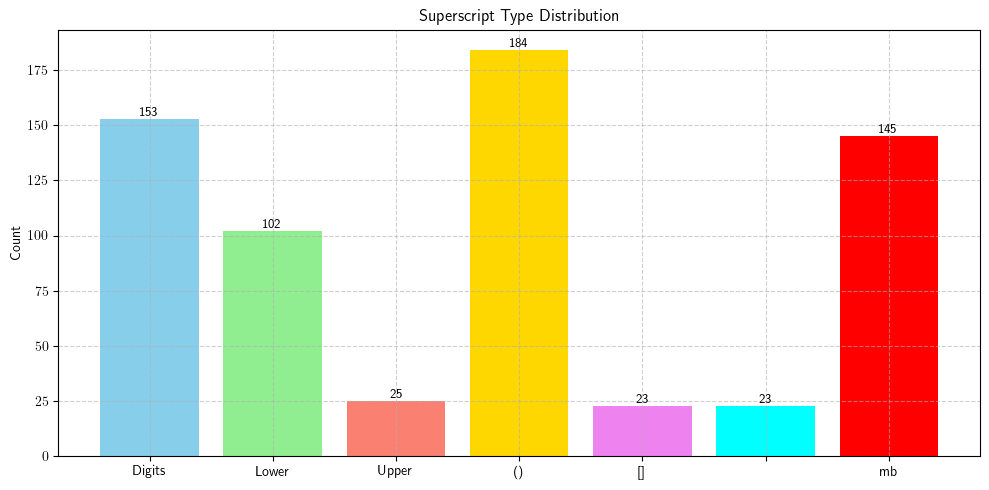


[INFO] Generating 60 superscripts:
  Digits:   30
  Lower:    18
  Upper:    12

[INFO] Final Distribution Summary:
Digits:     30
Lower:      18
Upper:      12


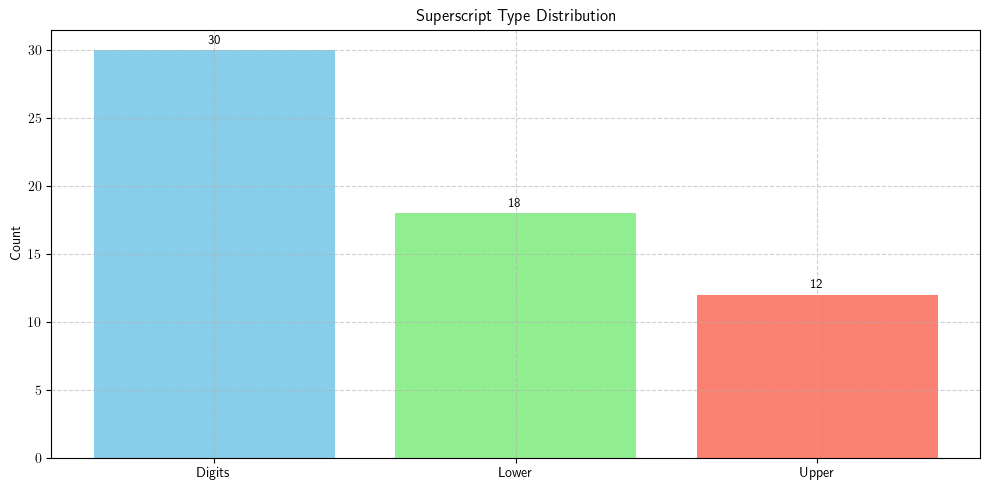


[INFO] Generating 30 superscripts:
  Digits:   9
  Lower:    6
  Upper:    1
  Brackets: 14

[INFO] Bracket styles:
  → ():     11
  → []:     1
  → {}:    2

[INFO] Bracket inner content distribution:
  → Digit-only:    7
  → Lower-only:    6
  → Upper-only:    1

[INFO] Final Distribution Summary:
Digits:     9
Lower:      6
Upper:      1
Brackets:   14
Multi Brackets : 7
multi round brackets : 5
multi square brackets : 0
multi curly brackets : 2
  → ():     11
  → []:     1
  → {}:     2


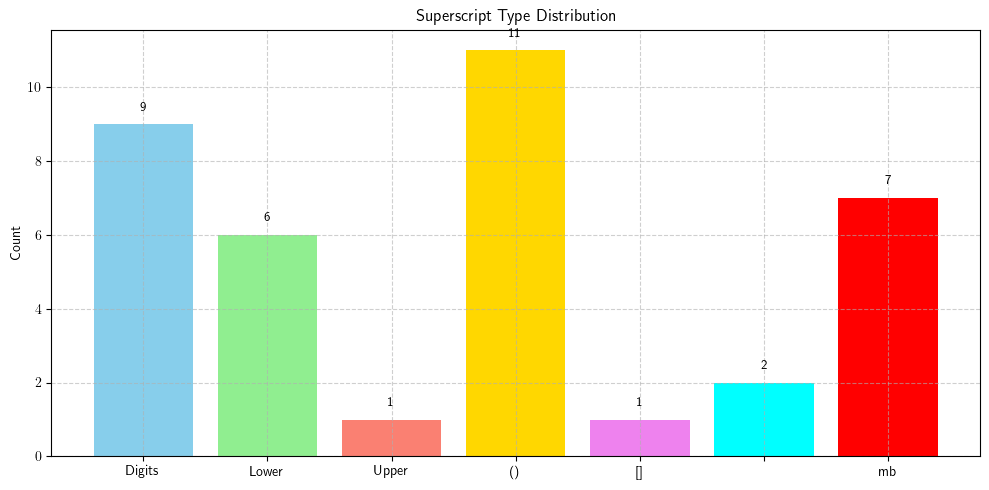


[INFO] Generating 30 superscripts:
  Digits:   15
  Lower:    9
  Upper:    6

[INFO] Final Distribution Summary:
Digits:     15
Lower:      9
Upper:      6


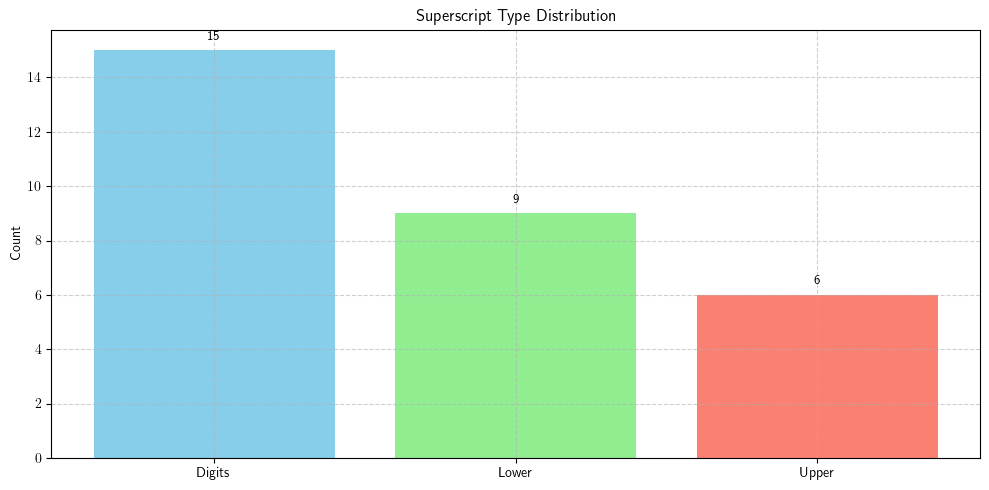

add_varies:  0.02
Find the map dictionary
 ===: mapping font size is:  3
Combined image saved to ./outputs_TR/test_final_ft/image/bg_img_background_img_26_NotoSans-Regular_3sz_super_-5,624.69_1,2,9_None.png
add_varies:  -0.01
Find the map dictionary
 ===: mapping font size is:  8
Combined image saved to ./outputs_TR/test_final_ft/image/solid_light_blue_NotoSans-Regular_8sz_super_transactions_1,2_None.png
add_varies:  -0.02
Find the map dictionary
 ===: mapping font size is:  5
Combined image saved to ./outputs_TR/test_final_ft/image/solid_light_red_NotoSans-Regular_5sz_super_US$_{a}_None.png
add_varies:  0.0
Find the map dictionary
 ===: mapping font size is:  4
Combined image saved to ./outputs_TR/test_final_ft/image/solid_light_blue_NotoSans-Regular_4sz_super_13__3_None.png
add_varies:  0.0
Find the map dictionary
 ===: mapping font size is:  6
Combined image saved to ./outputs_TR/test_final_ft/image/solid_light_yellow_NotoSans-Regular_6sz_super_tion_(a)(b)(s)_None.png
add_varies:  -

In [27]:
main_words_file  = "./data_1/test_2_TR_ft/train_main_text.txt"
run_generation_final(    
    main_words_file,
    num_of_img_per_font=50,
    output_folder="./outputs_TR/test_final_ft/",
    output_label="./outputs_TR/test_final_ft/",
    font_folder="../fonts",
    background_folder="../img_dir")

In [ ]:
main_words_file  = "./data_1/train_1_TR/train_main_text.txt"
run_generation_final(    
    main_words_file,
    num_of_img_per_font=80,
    output_folder="./outputs_TR/test_final/",
    output_label="./outputs_TR/test_final/",
    font_folder="../fonts",
    background_folder="../img_dir")

In [22]:
! rm -rf ./outputs_TR/test_final_ft